# $\text{Import libraries}$

## $\text{Based libraries}$

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from varname import argname
import polars as pl
from pathlib import Path
import subprocess
import shutil
import platform
import random

## $\text{Pytorch libraries}$

In [58]:
import torch
from torch import nn
from torch import tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchinfo import summary
import torchmetrics.classification as tmc

## $\text{Lightning libraries}$

In [59]:
import lightning.pytorch as ptl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from lightning.pytorch.tuner.tuning import Tuner

# $\text{Utils functions}$

In [74]:
def formatting_data(data_path: str) -> pl.DataFrame:
    name = argname("data_path")
    print(f"Reading {name}\n")
    raw_data: pl.DataFrame = pl.read_csv(data_path)
    class_col = raw_data.columns[-1]
    data = (
        raw_data.select(
            value=pl.concat_list(pl.exclude(class_col)), signal_class=pl.col(class_col)
        )
        .cast({"signal_class": pl.Int32})
        .sort("signal_class")
    )
    data_percentage = (
        data.group_by("signal_class")
        .agg(pl.count("value"))
        .sort("signal_class")
        .with_columns((pl.col("value") / pl.sum("value")).alias("percentage") * 100)
        .rename({"value": "count"})
    )
    print(data_percentage)
    return data, data_percentage

# $\text{Config class}$

In [62]:
class Config:
    def __init__(self, weight):
        self.train_split = 0.7
        self.val_split = 0.2
        self.test_split = 0.1
        self.lr = 0.0001
        self.weight = weight
        self.batch_size = 256

In [63]:
torch.manual_seed(6742)
random.seed(6742)

# $\text{Read and prepare data}$

In [64]:
path_train = Path("../../archive/mitbih_train.csv")
path_test = "../../archive/mitbih_test.csv"

In [102]:
data_train, data_train_percentage = formatting_data(path_train)

Reading path_train

shape: (5, 3)
┌──────────────┬───────┬────────────┐
│ signal_class ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ i32          ┆ u32   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ 0            ┆ 72470 ┆ 82.772721  │
│ 1            ┆ 2223  ┆ 2.539033   │
│ 2            ┆ 5788  ┆ 6.610853   │
│ 3            ┆ 641   ┆ 0.732128   │
│ 4            ┆ 6431  ┆ 7.345265   │
└──────────────┴───────┴────────────┘


In [113]:
cut_off_train = int(
    data_train_percentage[0, "count"] - np.ceil(data_train_percentage[1:, "count"].mean()))

In [114]:
data_train = data_train[cut_off_train:, :]

In [115]:
data_train_percentage = (
    data_train.group_by("signal_class")
    .agg(pl.count("value"))
    .sort("signal_class")
    .with_columns((pl.col("value") / pl.sum("value")).alias("percentage") * 100)
    .rename({"value": "count"})
)
print(data_train_percentage)

shape: (5, 3)
┌──────────────┬───────┬────────────┐
│ signal_class ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ i32          ┆ u32   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ 0            ┆ 3771  ┆ 20.001061  │
│ 1            ┆ 2223  ┆ 11.790601  │
│ 2            ┆ 5788  ┆ 30.699056  │
│ 3            ┆ 641   ┆ 3.399809   │
│ 4            ┆ 6431  ┆ 34.109473  │
└──────────────┴───────┴────────────┘


In [110]:
weights = 1 / data_train_percentage[:, -1].to_numpy()

In [111]:
CONFIG = Config(weights)

In [112]:
data_val, data_val_percentage = formatting_data(path_test)

Reading path_test

shape: (5, 3)
┌──────────────┬───────┬────────────┐
│ signal_class ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ i32          ┆ u32   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ 0            ┆ 18117 ┆ 82.760038  │
│ 1            ┆ 556   ┆ 2.539857   │
│ 2            ┆ 1448  ┆ 6.61459    │
│ 3            ┆ 162   ┆ 0.74003    │
│ 4            ┆ 1608  ┆ 7.345484   │
└──────────────┴───────┴────────────┘


In [116]:
cut_off_val = int(data_val_percentage[0, "count"] -
                  np.ceil(data_val_percentage[1:, "count"].mean()))

In [118]:
data_val = data_val[cut_off_val:, :]

data_val_percentage = (
    data_val.group_by("signal_class")
    .agg(pl.count("value"))
    .sort("signal_class")
    .with_columns((pl.col("value") / pl.sum("value")).alias("percentage") * 100)
    .rename({"value": "count"})
)
print(data_val_percentage)

shape: (5, 3)
┌──────────────┬───────┬────────────┐
│ signal_class ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ i32          ┆ u32   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ 0            ┆ 944   ┆ 20.008478  │
│ 1            ┆ 556   ┆ 11.784655  │
│ 2            ┆ 1448  ┆ 30.690971  │
│ 3            ┆ 162   ┆ 3.433658   │
│ 4            ┆ 1608  ┆ 34.082238  │
└──────────────┴───────┴────────────┘


In [119]:
data_train = data_train.sample(fraction=1, shuffle=True)
n = int(data_train.shape[0]*7/8)
data_train, data_test = data_train.head(n), data_train.tail(-n)

In [120]:
data_test.rows

<bound method DataFrame.rows of shape: (2_357, 2)
┌─────────────────────────────┬──────────────┐
│ value                       ┆ signal_class │
│ ---                         ┆ ---          │
│ list[f64]                   ┆ i32          │
╞═════════════════════════════╪══════════════╡
│ [1.0, 0.670886, … 0.0]      ┆ 0            │
│ [0.954751, 1.0, … 0.0]      ┆ 1            │
│ [1.0, 0.752941, … 0.0]      ┆ 3            │
│ [0.99, 0.83, … 0.275]       ┆ 1            │
│ [1.0, 0.950362, … 0.0]      ┆ 4            │
│ …                           ┆ …            │
│ [0.0, 0.067257, … 0.0]      ┆ 2            │
│ [1.0, 0.931548, … 0.0]      ┆ 4            │
│ [1.0, 0.818681, … 0.0]      ┆ 0            │
│ [1.0, 0.479021, … 0.0]      ┆ 4            │
│ [0.772496, 0.674024, … 0.0] ┆ 4            │
└─────────────────────────────┴──────────────┘>

In [121]:
data_train.rows

<bound method DataFrame.rows of shape: (16_497, 2)
┌─────────────────────────────────┬──────────────┐
│ value                           ┆ signal_class │
│ ---                             ┆ ---          │
│ list[f64]                       ┆ i32          │
╞═════════════════════════════════╪══════════════╡
│ [1.0, 0.944334, … 0.0]          ┆ 4            │
│ [0.472401, 0.42362, … 0.345315] ┆ 2            │
│ [1.0, 0.461735, … 0.0]          ┆ 0            │
│ [0.865094, 0.813208, … 0.0]     ┆ 4            │
│ [0.974648, 0.498592, … 0.0]     ┆ 0            │
│ …                               ┆ …            │
│ [0.043182, 0.123864, … 0.0]     ┆ 2            │
│ [0.647577, 0.85022, … 0.0]      ┆ 0            │
│ [0.922815, 0.869467, … 0.0]     ┆ 4            │
│ [0.714063, 0.620313, … 0.0]     ┆ 4            │
│ [0.962719, 0.995614, … 0.0]     ┆ 2            │
└─────────────────────────────────┴──────────────┘>

In [122]:
data_val.rows

<bound method DataFrame.rows of shape: (4_718, 2)
┌─────────────────────────────┬──────────────┐
│ value                       ┆ signal_class │
│ ---                         ┆ ---          │
│ list[f64]                   ┆ i32          │
╞═════════════════════════════╪══════════════╡
│ [0.978208, 0.910412, … 0.0] ┆ 0            │
│ [0.0, 0.05914, … 0.0]       ┆ 0            │
│ [1.0, 0.778267, … 0.0]      ┆ 0            │
│ [0.991525, 0.937288, … 0.0] ┆ 0            │
│ [1.0, 0.765909, … 0.0]      ┆ 0            │
│ …                           ┆ …            │
│ [0.928736, 0.871264, … 0.0] ┆ 4            │
│ [0.802691, 0.692078, … 0.0] ┆ 4            │
│ [1.0, 0.967359, … 0.0]      ┆ 4            │
│ [0.984127, 0.56746, … 0.0]  ┆ 4            │
│ [0.97397, 0.913232, … 0.0]  ┆ 4            │
└─────────────────────────────┴──────────────┘>

In [123]:
name_dict: dict[int, str] = {0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"}

# $\text{Make data config}$

In [124]:
class Signal_Dataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        signal = torch.tensor(self.data_df["value"][idx]).unsqueeze(0)
        label = torch.tensor(self.data_df["signal_class"][idx])
        return signal, label

In [125]:
class Dataset_config:
    def __init__(self, data_df, config):
        if not isinstance(data_df, list):
            self.data_dataset = Signal_Dataset(data_df)
            self.weight = torch.from_numpy(config.weights).float()
            self.train_size = int(config.train_split * len(self.data_dataset))
            self.val_size = int(config.val_split * len(self.data_dataset))
            self.test_size = len(self.data_dataset) - \
                self.train_size - self.val_size

            self.train_dataset, self.val_dataset, self.test_dataset = (
                torch.utils.data.random_split(
                    self.data_dataset, [self.train_size,
                                        self.val_size, self.test_size]
                )
            )
        else:
            self.train_dataset = Signal_Dataset(data_df[0])
            self.val_dataset = Signal_Dataset(data_df[1])
            self.test_dataset = Signal_Dataset(data_df[2])

        self.train_dataloader = DataLoader(
            self.train_dataset,
            shuffle=True,
            # num_workers=2,
            batch_size=config.batch_size,
        )
        self.val_dataloader = DataLoader(
            self.val_dataset,
            shuffle=False,
            # num_workers=2,
            batch_size=config.batch_size,
        )
        self.test_dataloader = DataLoader(
            self.test_dataset,
            shuffle=False,
            # num_workers=2,
            batch_size=config.batch_size,
        )

In [126]:
DATA_SIGNAL = Dataset_config([data_train, data_val, data_test], CONFIG)

In [130]:
DATA_SIGNAL.train_dataset.__len__(), \
DATA_SIGNAL.val_dataset.__len__(), \
DATA_SIGNAL.test_dataset.__len__()

(16497, 4718, 2357)

# $\text{Make model}$

## $\text{Base Pytorch model}$

In [131]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(32, 32, 5, padding="same")
        self.conv2 = nn.Conv1d(32, 32, 5, padding="same")
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(5, 2)

    def forward(self, signal):
        identity = signal
        signal = self.conv1(signal)
        signal = self.relu(signal)
        signal = self.conv2(signal)
        signal = identity + signal
        signal = self.relu(signal)
        signal = self.pool(signal)
        return signal


class Base_Pytorch_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding="same")
        self.Res_series = nn.Sequential(*[ResBlock()]*5)
        self.fc1 = nn.Linear(32, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 5)

    def forward(self, signal):
        signal = self.conv1(signal)
        signal = self.Res_series(signal)
        signal = signal.flatten(1)
        signal = nn.AdaptiveAvgPool1d(32)(signal)
        signal = self.fc1(signal)
        signal = self.relu(signal)
        signal = self.fc2(signal)
        return signal

In [132]:
ECG_model = Base_Pytorch_Model()

In [133]:
data_iter = iter(DATA_SIGNAL.train_dataloader)

In [134]:
summary(ECG_model, next(data_iter)[0].shape, depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
Base_Pytorch_Model                       [256, 5]                  --
├─Conv1d: 1-1                            [256, 32, 187]            192
├─Sequential: 1-2                        [256, 32, 2]              --
│    └─ResBlock: 2-1                     [256, 32, 92]             --
│    │    └─Conv1d: 3-1                  [256, 32, 187]            5,152
│    │    └─ReLU: 3-2                    [256, 32, 187]            --
│    │    └─Conv1d: 3-3                  [256, 32, 187]            5,152
│    │    └─ReLU: 3-4                    [256, 32, 187]            --
│    │    └─MaxPool1d: 3-5               [256, 32, 92]             --
│    └─ResBlock: 2-2                     [256, 32, 44]             (recursive)
│    │    └─Conv1d: 3-6                  [256, 32, 92]             (recursive)
│    │    └─ReLU: 3-7                    [256, 32, 92]             --
│    │    └─Conv1d: 3-8                  [256, 32, 92]      

## $\text{Lightning model}$

In [135]:
class Lightning_Wrapper(ptl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.learning_rate = config.lr
        if hasattr(config, "weight"):
            self.loss_fn = nn.CrossEntropyLoss(torch.tensor(config.weight).float())
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #         optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        return optimizer

    def forward(self, signal):
        return self.model(signal)

    # __________________TRAIN_____________________________________________________

    def training_step(self, batch, batch_idx):
        try:
            signal, label = batch
            result = self(signal)

            predicted_class = result.argmax(dim=-1).flatten()

            accuracy = predicted_class == label

            loss = self.loss_fn(result, label)

            logs = {
                "train_acc": accuracy.count_nonzero().item() / len(accuracy) * 100,
            }
            self.log_dict(logs)
            self.log("train_loss", loss, prog_bar=True)
            return loss
        except:
            print("Something wrong train upper")
            print(f"{batch_idx = }")
            print(f"{label.shape = }")
            print(f"{label.type() = }")
            print(f"{label = }")
            print(f"{result.shape = }")
            print(f"{result.type() = }")
            print(f"{result.mean(0) = }")
            print(f"{predicted_class = }")
            print(f"{accuracy = }")
            print(f"{loss = }\n\n")

    # __________________VALIDATION_____________________________________________________

    def validation_step(self, batch, batch_idx):
        try:
            signal, label = batch
            result = self(signal)

            predicted_class = result.argmax(dim=-1).flatten()

            accuracy = predicted_class == label

            loss = self.loss_fn(result, label)

            logs = {
                "val_acc": accuracy.count_nonzero().item() / len(accuracy) * 100,
            }
            self.log_dict(logs)
            self.log("val_loss", loss, prog_bar=True)
            return loss
        except:
            print("Something wrong val upper")
            print(f"{batch_idx = }")
            print(f"{label.shape = }")
            print(f"{label.type() = }")
            print(f"{label = }")
            print(f"{result.shape = }")
            print(f"{result.type() = }")
            print(f"{result.mean(0) = }")
            print(f"{predicted_class = }")
            print(f"{accuracy = }")
            print(f"{loss = }\n\n")

    # __________________TEST_____________________________________________________

    def test_step(self, batch, batch_idx):
        try:
            signal, label = batch
            result = self(signal)

            predicted_class = result.argmax(dim=-1).flatten()

            accuracy = predicted_class == label

            loss = self.loss_fn(result, label)

            logs = {
                "test_acc": accuracy.count_nonzero().item() / len(accuracy) * 100,
            }
            self.log_dict(logs)
            self.log("test_loss", loss, prog_bar=True)
            return loss
        except:
            print("Something wrong test upper")
            print(f"{batch_idx = }")
            print(f"{label.shape = }")
            print(f"{label.type() = }")
            print(f"{label = }")
            print(f"{result.shape = }")
            print(f"{result.type() = }")
            print(f"{result.mean(0) = }")
            print(f"{predicted_class = }")
            print(f"{accuracy = }")
            print(f"{loss = }\n\n")

    # _____________________PREDICT_____________________________________________________

    def predict_step(self, batch, batch_idx):
        try:
            signal, label = batch
            result = self(signal)

            return (result, label)
        except:
            print("Something wrong test upper")
            print(f"{batch_idx = }")
            print(f"{label.shape = }")
            print(f"{label.type() = }")
            print(f"{label = }")
            print(f"{result.shape = }")
            print(f"{result.type() = }")
            print(f"{result.mean(0) = }")

In [136]:
# base_model.cpu()
# lightning_model.cpu()
# del trainer, base_model, lightning_model
# del tuner

import gc
gc.collect()

1350

# $\text{Logging}$

In [137]:
shutil.rmtree("lightning_logs", ignore_errors=True)
Path("lightning_logs").mkdir(exist_ok=True)

In [138]:
try:
    if platform.system() == "Windows":
        subprocess.run(["kill", "-name" "tensorboard"])
    else:
        subprocess.run(["killall", "tensorboard"])
except:
    pass

In [139]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs --port=6006

Reusing TensorBoard on port 6006 (pid 31256), started 3:51:54 ago. (Use '!kill 31256' to kill it.)

In [140]:
logger = TensorBoardLogger("lightning_logs",
                           name="",
                           version=0
                           )
checkpoint_callback_train = ModelCheckpoint(
    save_top_k=1,
    monitor="train_loss",
    # mode="min",
    dirpath="lightning_logs/version_0/checkpoints/train/",
    filename="train_model-{epoch}-{train_loss}-{val_loss}",
    verbose=True,
    # every_n_train_steps = 100,
    save_on_train_epoch_end=True
)
checkpoint_callback_val = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    # mode="min",
    dirpath="lightning_logs/version_0/checkpoints/val/",
    filename="val_model-{epoch}-{train_loss}-{val_loss}",
    verbose=True,
    # every_n_train_steps = 100,
    save_on_train_epoch_end=True
)

trainer = ptl.Trainer(
    #     fast_dev_run = True,
    max_epochs=100,
    callbacks=[
        # utils_callbacks,
        checkpoint_callback_train,
        checkpoint_callback_val
    ],
    #     profiler="simple",
    accelerator="auto",
    #     accumulate_grad_batches=64,
    benchmark=True,
    # check_val_every_n_epoch=1,
    #     gradient_clip_val = 0.5,
    logger=logger,
    log_every_n_steps=100,
)

base_model = Base_Pytorch_Model()
lightning_model = Lightning_Wrapper(base_model, CONFIG)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# $\text{Trainning step}$

In [141]:
tuner = Tuner(trainer)
tuner.lr_find(lightning_model,
              train_dataloaders=DATA_SIGNAL.train_dataloader,
              val_dataloaders=DATA_SIGNAL.val_dataloader,
              )

trainer.fit(lightning_model,
            train_dataloaders=DATA_SIGNAL.train_dataloader,
            val_dataloaders=DATA_SIGNAL.val_dataloader,
            )

c:\Users\ngako\AppData\Local\anaconda3\envs\ML_med\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\ngako\AppData\Local\anaconda3\envs\ML_med\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (65) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\ngako\AppData\Local\anaconda3\envs\ML_med\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
Finding best initial lr:  92%|█████████

Epoch 0: 100%|██████████| 65/65 [00:16<00:00,  3.99it/s, v_num=0, train_loss=0.913, val_loss=0.783]

Epoch 0, global step 65: 'train_loss' reached 0.91313 (best 0.91313), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=0-train_loss=0.9131316542625427-val_loss=0.783460795879364.ckpt' as top 1
Epoch 0, global step 65: 'val_loss' reached 0.78346 (best 0.78346), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=0-train_loss=0.9131316542625427-val_loss=0.783460795879364.ckpt' as top 1


Epoch 1: 100%|██████████| 65/65 [00:15<00:00,  4.10it/s, v_num=0, train_loss=0.517, val_loss=0.518]

Epoch 1, global step 130: 'train_loss' reached 0.51653 (best 0.51653), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=1-train_loss=0.5165260434150696-val_loss=0.5181528329849243.ckpt' as top 1
Epoch 1, global step 130: 'val_loss' reached 0.51815 (best 0.51815), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=1-train_loss=0.5165260434150696-val_loss=0.5181528329849243.ckpt' as top 1


Epoch 2: 100%|██████████| 65/65 [00:15<00:00,  4.17it/s, v_num=0, train_loss=0.431, val_loss=0.400]

Epoch 2, global step 195: 'train_loss' reached 0.43131 (best 0.43131), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=2-train_loss=0.431309312582016-val_loss=0.4002872109413147.ckpt' as top 1
Epoch 2, global step 195: 'val_loss' reached 0.40029 (best 0.40029), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=2-train_loss=0.431309312582016-val_loss=0.4002872109413147.ckpt' as top 1


Epoch 3: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.198, val_loss=0.356]

Epoch 3, global step 260: 'train_loss' reached 0.19824 (best 0.19824), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=3-train_loss=0.19823631644248962-val_loss=0.35578590631484985.ckpt' as top 1
Epoch 3, global step 260: 'val_loss' reached 0.35579 (best 0.35579), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=3-train_loss=0.19823631644248962-val_loss=0.35578590631484985.ckpt' as top 1


Epoch 4: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.421, val_loss=0.414]

Epoch 4, global step 325: 'train_loss' was not in top 1
Epoch 4, global step 325: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.261, val_loss=0.294]

Epoch 5, global step 390: 'train_loss' was not in top 1
Epoch 5, global step 390: 'val_loss' reached 0.29437 (best 0.29437), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=5-train_loss=0.2605293095111847-val_loss=0.2943652868270874.ckpt' as top 1


Epoch 6: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.309, val_loss=0.299]

Epoch 6, global step 455: 'train_loss' was not in top 1
Epoch 6, global step 455: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.357, val_loss=0.315]

Epoch 7, global step 520: 'train_loss' was not in top 1
Epoch 7, global step 520: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 65/65 [00:15<00:00,  4.16it/s, v_num=0, train_loss=0.356, val_loss=0.268]

Epoch 8, global step 585: 'train_loss' was not in top 1
Epoch 8, global step 585: 'val_loss' reached 0.26834 (best 0.26834), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=8-train_loss=0.355684757232666-val_loss=0.2683413326740265.ckpt' as top 1


Epoch 9: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.271, val_loss=0.272]

Epoch 9, global step 650: 'train_loss' was not in top 1
Epoch 9, global step 650: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 65/65 [00:15<00:00,  4.22it/s, v_num=0, train_loss=0.206, val_loss=0.311]

Epoch 10, global step 715: 'train_loss' was not in top 1
Epoch 10, global step 715: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 65/65 [00:15<00:00,  4.26it/s, v_num=0, train_loss=0.164, val_loss=0.302]

Epoch 11, global step 780: 'train_loss' reached 0.16444 (best 0.16444), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=11-train_loss=0.1644367277622223-val_loss=0.3023366332054138.ckpt' as top 1
Epoch 11, global step 780: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.214, val_loss=0.265]

Epoch 12, global step 845: 'train_loss' was not in top 1
Epoch 12, global step 845: 'val_loss' reached 0.26535 (best 0.26535), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=12-train_loss=0.21381531655788422-val_loss=0.26535364985466003.ckpt' as top 1


Epoch 13: 100%|██████████| 65/65 [00:15<00:00,  4.21it/s, v_num=0, train_loss=0.084, val_loss=0.252]

Epoch 13, global step 910: 'train_loss' reached 0.08398 (best 0.08398), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=13-train_loss=0.08397546410560608-val_loss=0.25223925709724426.ckpt' as top 1
Epoch 13, global step 910: 'val_loss' reached 0.25224 (best 0.25224), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=13-train_loss=0.08397546410560608-val_loss=0.25223925709724426.ckpt' as top 1


Epoch 14: 100%|██████████| 65/65 [00:16<00:00,  4.04it/s, v_num=0, train_loss=0.281, val_loss=0.250]

Epoch 14, global step 975: 'train_loss' was not in top 1
Epoch 14, global step 975: 'val_loss' reached 0.25026 (best 0.25026), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=14-train_loss=0.28143036365509033-val_loss=0.2502567768096924.ckpt' as top 1


Epoch 15: 100%|██████████| 65/65 [00:17<00:00,  3.63it/s, v_num=0, train_loss=0.114, val_loss=0.241]

Epoch 15, global step 1040: 'train_loss' was not in top 1
Epoch 15, global step 1040: 'val_loss' reached 0.24062 (best 0.24062), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=15-train_loss=0.11356844753026962-val_loss=0.24061600863933563.ckpt' as top 1


Epoch 16: 100%|██████████| 65/65 [00:17<00:00,  3.75it/s, v_num=0, train_loss=0.208, val_loss=0.233]

Epoch 16, global step 1105: 'train_loss' was not in top 1
Epoch 16, global step 1105: 'val_loss' reached 0.23314 (best 0.23314), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=16-train_loss=0.20806004106998444-val_loss=0.23313698172569275.ckpt' as top 1


Epoch 17: 100%|██████████| 65/65 [00:18<00:00,  3.44it/s, v_num=0, train_loss=0.208, val_loss=0.229] 

Epoch 17, global step 1170: 'train_loss' was not in top 1
Epoch 17, global step 1170: 'val_loss' reached 0.22896 (best 0.22896), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=17-train_loss=0.20781207084655762-val_loss=0.2289639562368393.ckpt' as top 1


Epoch 18: 100%|██████████| 65/65 [00:18<00:00,  3.47it/s, v_num=0, train_loss=0.228, val_loss=0.254] 

Epoch 18, global step 1235: 'train_loss' was not in top 1
Epoch 18, global step 1235: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 65/65 [00:15<00:00,  4.28it/s, v_num=0, train_loss=0.118, val_loss=0.270]

Epoch 19, global step 1300: 'train_loss' was not in top 1
Epoch 19, global step 1300: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 65/65 [00:15<00:00,  4.27it/s, v_num=0, train_loss=0.325, val_loss=0.234] 

Epoch 20, global step 1365: 'train_loss' was not in top 1
Epoch 20, global step 1365: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 65/65 [00:15<00:00,  4.29it/s, v_num=0, train_loss=0.185, val_loss=0.292] 

Epoch 21, global step 1430: 'train_loss' was not in top 1
Epoch 21, global step 1430: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 65/65 [00:14<00:00,  4.34it/s, v_num=0, train_loss=0.262, val_loss=0.229] 

Epoch 22, global step 1495: 'train_loss' was not in top 1
Epoch 22, global step 1495: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 65/65 [00:19<00:00,  3.41it/s, v_num=0, train_loss=0.328, val_loss=0.256] 

Epoch 23, global step 1560: 'train_loss' was not in top 1
Epoch 23, global step 1560: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 65/65 [00:17<00:00,  3.73it/s, v_num=0, train_loss=0.209, val_loss=0.215] 

Epoch 24, global step 1625: 'train_loss' was not in top 1
Epoch 24, global step 1625: 'val_loss' reached 0.21537 (best 0.21537), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=24-train_loss=0.2085161656141281-val_loss=0.2153678983449936.ckpt' as top 1


Epoch 25: 100%|██████████| 65/65 [00:17<00:00,  3.76it/s, v_num=0, train_loss=0.242, val_loss=0.240] 

Epoch 25, global step 1690: 'train_loss' was not in top 1
Epoch 25, global step 1690: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 65/65 [00:16<00:00,  4.05it/s, v_num=0, train_loss=0.119, val_loss=0.210] 

Epoch 26, global step 1755: 'train_loss' was not in top 1
Epoch 26, global step 1755: 'val_loss' reached 0.21019 (best 0.21019), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=26-train_loss=0.11890215426683426-val_loss=0.21018508076667786.ckpt' as top 1


Epoch 27: 100%|██████████| 65/65 [00:15<00:00,  4.23it/s, v_num=0, train_loss=0.264, val_loss=0.214] 

Epoch 27, global step 1820: 'train_loss' was not in top 1
Epoch 27, global step 1820: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s, v_num=0, train_loss=0.138, val_loss=0.238] 

Epoch 28, global step 1885: 'train_loss' was not in top 1
Epoch 28, global step 1885: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s, v_num=0, train_loss=0.107, val_loss=0.213] 

Epoch 29, global step 1950: 'train_loss' was not in top 1
Epoch 29, global step 1950: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 65/65 [00:15<00:00,  4.19it/s, v_num=0, train_loss=0.130, val_loss=0.231] 

Epoch 30, global step 2015: 'train_loss' was not in top 1
Epoch 30, global step 2015: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 65/65 [00:15<00:00,  4.22it/s, v_num=0, train_loss=0.354, val_loss=0.222] 

Epoch 31, global step 2080: 'train_loss' was not in top 1
Epoch 31, global step 2080: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 65/65 [00:16<00:00,  4.03it/s, v_num=0, train_loss=0.206, val_loss=0.241] 

Epoch 32, global step 2145: 'train_loss' was not in top 1
Epoch 32, global step 2145: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 65/65 [00:18<00:00,  3.54it/s, v_num=0, train_loss=0.135, val_loss=0.207]

Epoch 33, global step 2210: 'train_loss' was not in top 1
Epoch 33, global step 2210: 'val_loss' reached 0.20725 (best 0.20725), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=33-train_loss=0.13548490405082703-val_loss=0.20724502205848694.ckpt' as top 1


Epoch 34: 100%|██████████| 65/65 [00:18<00:00,  3.54it/s, v_num=0, train_loss=0.197, val_loss=0.214] 

Epoch 34, global step 2275: 'train_loss' was not in top 1
Epoch 34, global step 2275: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s, v_num=0, train_loss=0.172, val_loss=0.221] 

Epoch 35, global step 2340: 'train_loss' was not in top 1
Epoch 35, global step 2340: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s, v_num=0, train_loss=0.288, val_loss=0.279] 

Epoch 36, global step 2405: 'train_loss' was not in top 1
Epoch 36, global step 2405: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 65/65 [00:15<00:00,  4.29it/s, v_num=0, train_loss=0.132, val_loss=0.240] 

Epoch 37, global step 2470: 'train_loss' was not in top 1
Epoch 37, global step 2470: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 65/65 [00:15<00:00,  4.19it/s, v_num=0, train_loss=0.121, val_loss=0.309] 

Epoch 38, global step 2535: 'train_loss' was not in top 1
Epoch 38, global step 2535: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 65/65 [00:15<00:00,  4.25it/s, v_num=0, train_loss=0.105, val_loss=0.228] 

Epoch 39, global step 2600: 'train_loss' was not in top 1
Epoch 39, global step 2600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.159, val_loss=0.255] 

Epoch 40, global step 2665: 'train_loss' was not in top 1
Epoch 40, global step 2665: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 65/65 [00:16<00:00,  3.95it/s, v_num=0, train_loss=0.193, val_loss=0.257] 

Epoch 41, global step 2730: 'train_loss' was not in top 1
Epoch 41, global step 2730: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.180, val_loss=0.243] 

Epoch 42, global step 2795: 'train_loss' was not in top 1
Epoch 42, global step 2795: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.137, val_loss=0.225] 

Epoch 43, global step 2860: 'train_loss' was not in top 1
Epoch 43, global step 2860: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 65/65 [00:15<00:00,  4.18it/s, v_num=0, train_loss=0.0405, val_loss=0.218]

Epoch 44, global step 2925: 'train_loss' reached 0.04046 (best 0.04046), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=44-train_loss=0.04046323150396347-val_loss=0.2181652933359146.ckpt' as top 1
Epoch 44, global step 2925: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 65/65 [00:15<00:00,  4.14it/s, v_num=0, train_loss=0.166, val_loss=0.246] 

Epoch 45, global step 2990: 'train_loss' was not in top 1
Epoch 45, global step 2990: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.275, val_loss=0.215] 

Epoch 46, global step 3055: 'train_loss' was not in top 1
Epoch 46, global step 3055: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 65/65 [00:15<00:00,  4.14it/s, v_num=0, train_loss=0.104, val_loss=0.214] 

Epoch 47, global step 3120: 'train_loss' was not in top 1
Epoch 47, global step 3120: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.253, val_loss=0.354] 

Epoch 48, global step 3185: 'train_loss' was not in top 1
Epoch 48, global step 3185: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.221, val_loss=0.291] 

Epoch 49, global step 3250: 'train_loss' was not in top 1
Epoch 49, global step 3250: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.145, val_loss=0.226] 

Epoch 50, global step 3315: 'train_loss' was not in top 1
Epoch 50, global step 3315: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.161, val_loss=0.264] 

Epoch 51, global step 3380: 'train_loss' was not in top 1
Epoch 51, global step 3380: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 65/65 [00:16<00:00,  4.06it/s, v_num=0, train_loss=0.161, val_loss=0.206] 

Epoch 52, global step 3445: 'train_loss' was not in top 1
Epoch 52, global step 3445: 'val_loss' reached 0.20648 (best 0.20648), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=52-train_loss=0.16084441542625427-val_loss=0.20647922158241272.ckpt' as top 1


Epoch 53: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.176, val_loss=0.236] 

Epoch 53, global step 3510: 'train_loss' was not in top 1
Epoch 53, global step 3510: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.144, val_loss=0.212] 

Epoch 54, global step 3575: 'train_loss' was not in top 1
Epoch 54, global step 3575: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 65/65 [00:15<00:00,  4.08it/s, v_num=0, train_loss=0.135, val_loss=0.244] 

Epoch 55, global step 3640: 'train_loss' was not in top 1
Epoch 55, global step 3640: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.343, val_loss=0.230] 

Epoch 56, global step 3705: 'train_loss' was not in top 1
Epoch 56, global step 3705: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.155, val_loss=0.253] 

Epoch 57, global step 3770: 'train_loss' was not in top 1
Epoch 57, global step 3770: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.135, val_loss=0.220] 

Epoch 58, global step 3835: 'train_loss' was not in top 1
Epoch 58, global step 3835: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.129, val_loss=0.230] 

Epoch 59, global step 3900: 'train_loss' was not in top 1
Epoch 59, global step 3900: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 65/65 [00:15<00:00,  4.19it/s, v_num=0, train_loss=0.065, val_loss=0.220] 

Epoch 60, global step 3965: 'train_loss' was not in top 1
Epoch 60, global step 3965: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 65/65 [00:18<00:00,  3.59it/s, v_num=0, train_loss=0.127, val_loss=0.223] 

Epoch 61, global step 4030: 'train_loss' was not in top 1
Epoch 61, global step 4030: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s, v_num=0, train_loss=0.111, val_loss=0.208] 

Epoch 62, global step 4095: 'train_loss' was not in top 1
Epoch 62, global step 4095: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 65/65 [00:15<00:00,  4.16it/s, v_num=0, train_loss=0.126, val_loss=0.261] 

Epoch 63, global step 4160: 'train_loss' was not in top 1
Epoch 63, global step 4160: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.124, val_loss=0.207] 

Epoch 64, global step 4225: 'train_loss' was not in top 1
Epoch 64, global step 4225: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.231, val_loss=0.241] 

Epoch 65, global step 4290: 'train_loss' was not in top 1
Epoch 65, global step 4290: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 65/65 [00:15<00:00,  4.09it/s, v_num=0, train_loss=0.214, val_loss=0.222]

Epoch 66, global step 4355: 'train_loss' was not in top 1
Epoch 66, global step 4355: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.135, val_loss=0.211] 

Epoch 67, global step 4420: 'train_loss' was not in top 1
Epoch 67, global step 4420: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.299, val_loss=0.175] 

Epoch 68, global step 4485: 'train_loss' was not in top 1
Epoch 68, global step 4485: 'val_loss' reached 0.17528 (best 0.17528), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\val\\val_model-epoch=68-train_loss=0.29906609654426575-val_loss=0.1752772480249405.ckpt' as top 1


Epoch 69: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s, v_num=0, train_loss=0.201, val_loss=0.245] 

Epoch 69, global step 4550: 'train_loss' was not in top 1
Epoch 69, global step 4550: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 65/65 [00:18<00:00,  3.48it/s, v_num=0, train_loss=0.107, val_loss=0.186] 

Epoch 70, global step 4615: 'train_loss' was not in top 1
Epoch 70, global step 4615: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 65/65 [00:15<00:00,  4.14it/s, v_num=0, train_loss=0.284, val_loss=0.238] 

Epoch 71, global step 4680: 'train_loss' was not in top 1
Epoch 71, global step 4680: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 65/65 [00:15<00:00,  4.17it/s, v_num=0, train_loss=0.138, val_loss=0.223] 

Epoch 72, global step 4745: 'train_loss' was not in top 1
Epoch 72, global step 4745: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 65/65 [00:18<00:00,  3.46it/s, v_num=0, train_loss=0.165, val_loss=0.262] 

Epoch 73, global step 4810: 'train_loss' was not in top 1
Epoch 73, global step 4810: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s, v_num=0, train_loss=0.0946, val_loss=0.203]

Epoch 74, global step 4875: 'train_loss' was not in top 1
Epoch 74, global step 4875: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.161, val_loss=0.218] 

Epoch 75, global step 4940: 'train_loss' was not in top 1
Epoch 75, global step 4940: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 65/65 [00:15<00:00,  4.16it/s, v_num=0, train_loss=0.160, val_loss=0.222] 

Epoch 76, global step 5005: 'train_loss' was not in top 1
Epoch 76, global step 5005: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 65/65 [00:15<00:00,  4.17it/s, v_num=0, train_loss=0.146, val_loss=0.225] 

Epoch 77, global step 5070: 'train_loss' was not in top 1
Epoch 77, global step 5070: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s, v_num=0, train_loss=0.0209, val_loss=0.203]

Epoch 78, global step 5135: 'train_loss' reached 0.02090 (best 0.02090), saving model to 'D:\\Downloads\\Documents\\Years 3\\ML in med\\mlmed2024\\Practice\\Practice 1\\src\\Jupyter notebook\\lightning_logs\\version_0\\checkpoints\\train\\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt' as top 1
Epoch 78, global step 5135: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 65/65 [00:15<00:00,  4.09it/s, v_num=0, train_loss=0.121, val_loss=0.233] 

Epoch 79, global step 5200: 'train_loss' was not in top 1
Epoch 79, global step 5200: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 65/65 [00:15<00:00,  4.09it/s, v_num=0, train_loss=0.0539, val_loss=0.203]

Epoch 80, global step 5265: 'train_loss' was not in top 1
Epoch 80, global step 5265: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 65/65 [00:15<00:00,  4.17it/s, v_num=0, train_loss=0.110, val_loss=0.253] 

Epoch 81, global step 5330: 'train_loss' was not in top 1
Epoch 81, global step 5330: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s, v_num=0, train_loss=0.0708, val_loss=0.222]

Epoch 82, global step 5395: 'train_loss' was not in top 1
Epoch 82, global step 5395: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.0719, val_loss=0.252]

Epoch 83, global step 5460: 'train_loss' was not in top 1
Epoch 83, global step 5460: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 65/65 [00:15<00:00,  4.11it/s, v_num=0, train_loss=0.124, val_loss=0.225] 

Epoch 84, global step 5525: 'train_loss' was not in top 1
Epoch 84, global step 5525: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 65/65 [00:17<00:00,  3.62it/s, v_num=0, train_loss=0.100, val_loss=0.221] 

Epoch 85, global step 5590: 'train_loss' was not in top 1
Epoch 85, global step 5590: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s, v_num=0, train_loss=0.0487, val_loss=0.199]

Epoch 86, global step 5655: 'train_loss' was not in top 1
Epoch 86, global step 5655: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 65/65 [00:16<00:00,  3.97it/s, v_num=0, train_loss=0.0821, val_loss=0.215]

Epoch 87, global step 5720: 'train_loss' was not in top 1
Epoch 87, global step 5720: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 65/65 [00:16<00:00,  4.02it/s, v_num=0, train_loss=0.125, val_loss=0.259] 

Epoch 88, global step 5785: 'train_loss' was not in top 1
Epoch 88, global step 5785: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 65/65 [00:16<00:00,  4.00it/s, v_num=0, train_loss=0.123, val_loss=0.213] 

Epoch 89, global step 5850: 'train_loss' was not in top 1
Epoch 89, global step 5850: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 65/65 [00:15<00:00,  4.10it/s, v_num=0, train_loss=0.221, val_loss=0.259] 

Epoch 90, global step 5915: 'train_loss' was not in top 1
Epoch 90, global step 5915: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 65/65 [00:15<00:00,  4.15it/s, v_num=0, train_loss=0.166, val_loss=0.251] 

Epoch 91, global step 5980: 'train_loss' was not in top 1
Epoch 91, global step 5980: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 65/65 [00:15<00:00,  4.10it/s, v_num=0, train_loss=0.0825, val_loss=0.239]

Epoch 92, global step 6045: 'train_loss' was not in top 1
Epoch 92, global step 6045: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 65/65 [00:15<00:00,  4.08it/s, v_num=0, train_loss=0.039, val_loss=0.209] 

Epoch 93, global step 6110: 'train_loss' was not in top 1
Epoch 93, global step 6110: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 65/65 [00:15<00:00,  4.20it/s, v_num=0, train_loss=0.0359, val_loss=0.215]

Epoch 94, global step 6175: 'train_loss' was not in top 1
Epoch 94, global step 6175: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 65/65 [00:15<00:00,  4.22it/s, v_num=0, train_loss=0.152, val_loss=0.236] 

Epoch 95, global step 6240: 'train_loss' was not in top 1
Epoch 95, global step 6240: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 65/65 [00:15<00:00,  4.20it/s, v_num=0, train_loss=0.0856, val_loss=0.254]

Epoch 96, global step 6305: 'train_loss' was not in top 1
Epoch 96, global step 6305: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 65/65 [00:15<00:00,  4.24it/s, v_num=0, train_loss=0.0495, val_loss=0.220]

Epoch 97, global step 6370: 'train_loss' was not in top 1
Epoch 97, global step 6370: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 65/65 [00:15<00:00,  4.18it/s, v_num=0, train_loss=0.167, val_loss=0.282] 

Epoch 98, global step 6435: 'train_loss' was not in top 1
Epoch 98, global step 6435: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 65/65 [00:15<00:00,  4.21it/s, v_num=0, train_loss=0.109, val_loss=0.224] 

Epoch 99, global step 6500: 'train_loss' was not in top 1
Epoch 99, global step 6500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 65/65 [00:15<00:00,  4.21it/s, v_num=0, train_loss=0.109, val_loss=0.224]


# $\text{Testing step}$

## $\text{Train model best}$

In [142]:
train_pth = list(Path("lightning_logs").rglob("train_model*.ckpt"))[0]
print(train_pth)

lightning_logs\version_0\checkpoints\train\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt


In [143]:
train_result = trainer.test(
    lightning_model, dataloaders=DATA_SIGNAL.test_dataloader, ckpt_path=train_pth
)

Restoring states from the checkpoint path at lightning_logs\version_0\checkpoints\train\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt
Loaded model weights from the checkpoint at lightning_logs\version_0\checkpoints\train\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt
c:\Users\ngako\AppData\Local\anaconda3\envs\ML_med\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 10.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             94.48451232910156
        test_loss           0.2267870157957077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## $\text{Val model best}$

In [144]:
val_pth = list(Path("lightning_logs").rglob("val_model*.ckpt"))[0]
print(val_pth)

lightning_logs\version_0\checkpoints\val\val_model-epoch=68-train_loss=0.29906609654426575-val_loss=0.1752772480249405.ckpt


In [145]:
val_result = trainer.test(
    lightning_model, dataloaders=DATA_SIGNAL.test_dataloader, ckpt_path=val_pth
)

Restoring states from the checkpoint path at lightning_logs\version_0\checkpoints\val\val_model-epoch=68-train_loss=0.29906609654426575-val_loss=0.1752772480249405.ckpt
Loaded model weights from the checkpoint at lightning_logs\version_0\checkpoints\val\val_model-epoch=68-train_loss=0.29906609654426575-val_loss=0.1752772480249405.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 10.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             95.20577239990234
        test_loss           0.23044109344482422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [146]:
if train_result[0]["test_loss"] < val_result[0]["test_loss"]:
    best_model_path = train_pth
    print("Train model is better")
    print(f"train_model loss = {train_result[0]['test_loss']}")
    print(f"train_model accuracy = {train_result[0]['test_acc']}")
else:
    best_model_path = val_pth
    print("Val model is better")
    print(f"val_model loss = {val_result[0]['test_loss']}")
    print(f"val_model accuracy = {val_result[0]['test_acc']}")

Train model is better
train_model loss = 0.2267870157957077
train_model accuracy = 94.48451232910156


# $\text{Predicting step}$

In [147]:
result = trainer.predict(
    lightning_model, dataloaders=DATA_SIGNAL.test_dataloader, ckpt_path=best_model_path
)

Restoring states from the checkpoint path at lightning_logs\version_0\checkpoints\train\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt
Loaded model weights from the checkpoint at lightning_logs\version_0\checkpoints\train\train_model-epoch=78-train_loss=0.020902056246995926-val_loss=0.20266802608966827.ckpt
c:\Users\ngako\AppData\Local\anaconda3\envs\ML_med\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


In [148]:
predict_output = nn.Softmax(dim=-1)(torch.cat([x[0] for x in result]))
predict_truth = torch.cat([x[1] for x in result])
predict_class = predict_output.argmax(dim=-1)
num_class = len(torch.unique(predict_truth))

# $\text{Metrics calculation}$

## $\text{Accuracy}$

In [149]:
accuracy = tmc.MulticlassAccuracy(
    num_classes=num_class,
    average="none"
)
accuracy(predict_output, predict_truth)

tensor([0.8594, 0.9336, 0.9536, 0.9565, 0.9855])

## $\text{Precision}$

In [151]:
precision = tmc.MulticlassPrecision(
    num_classes=num_class,
    average="none",
)

precision(predict_output, predict_truth)

tensor([0.9312, 0.8669, 0.9790, 0.6226, 0.9927])

## $\text{Recall}$

In [152]:
recall = tmc.MulticlassRecall(
    num_classes=num_class,
    average="none",
)

recall(predict_output, predict_truth)

tensor([0.8594, 0.9336, 0.9536, 0.9565, 0.9855])

## $\text{F1 score}$

In [153]:
F1_score = tmc.MulticlassF1Score(
    num_classes=num_class,
    average='none',
)

F1_score(predict_output, predict_truth)

tensor([0.8939, 0.8990, 0.9661, 0.7543, 0.9891])

## $\text{ROC}$

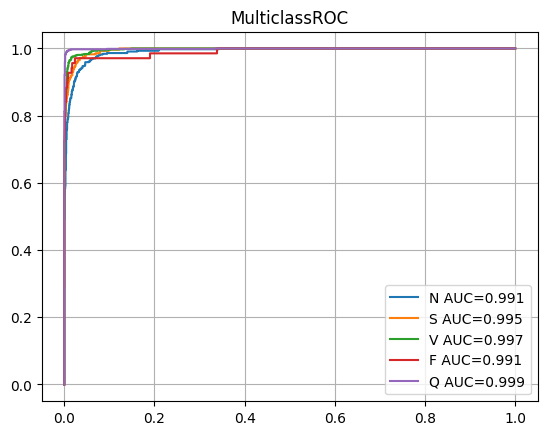

In [189]:
ROC = tmc.MulticlassROC(
    num_classes=num_class,
)

ROC.update(predict_output, predict_truth)

fig_ROC, ax_ROC = ROC.plot(score=True)

handle_ROC, label_ROC = ax_ROC.get_legend_handles_labels()
label_ROC = [f"{name_dict[int(x.split()[0])]} {x.split()[1]}" for x in label_ROC]
ax_ROC.legend(handle_ROC, label_ROC)

plt.show()

## $\text{Precision Recall curve}$

['N AUC=-0.967', 'S AUC=-0.971', 'V AUC=-0.994', 'F AUC=-0.934', 'Q AUC=-0.999']


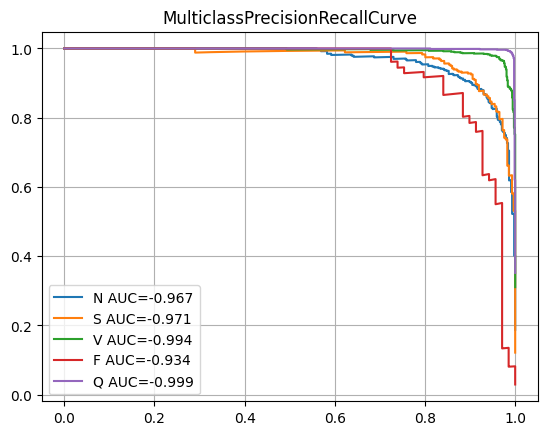

In [187]:
PRC = tmc.MulticlassPrecisionRecallCurve(
    num_classes=num_class,
)

PRC.update(predict_output, predict_truth)

fig_PRC, ax_PRC = PRC.plot(score=True)
handles, previous_labels = ax_PRC.get_legend_handles_labels()

previous_labels = [f"{name_dict[int(x.split()[0])]} {x.split()[1]}" for x in previous_labels]
print(previous_labels)
ax_PRC.legend(handles, previous_labels)

plt.show()

## $\text{Confusion matrix}$

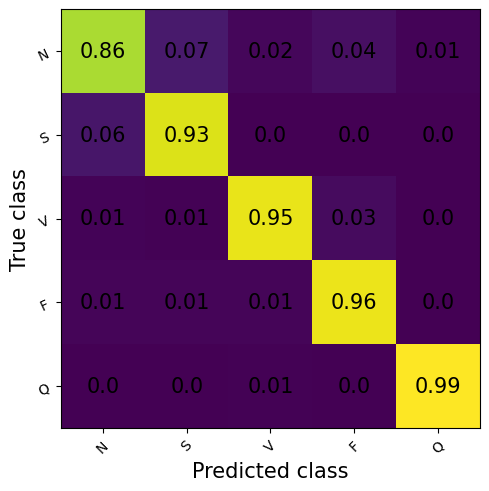

In [156]:
confusion_matrix = tmc.MulticlassConfusionMatrix(
    num_classes=num_class,
    normalize='true',
)

confusion_matrix.update(predict_class, predict_truth)

fig_confusion_matrix, ax_confusion_matrix = confusion_matrix.plot(
    labels=name_dict.values())
plt.show()